In [1]:
import wfdb

모든 데이터에 각 클래스 별 몇 개의 데이터가 들어있는지 데이터 개수 확인

In [2]:
# 데이터 셋 리스트
records = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

#AMMI 분류
aami_classes = {
    'N': ['N', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F'],
    'Q': ['/', 'f', 'Q']
}

# ammi_counters라는 딕셔너리를 생성하여 각 key값은 aami_classes로 설정하고, value는 0으로 초기화
aami_counters = {key: 0 for key in aami_classes}


for record in records: # 각 record 파일 탐색
    annotation = wfdb.rdann(f'data/{record}', 'atr') # atr 파일을 읽음
    for symbol in annotation.symbol: # annotaion에 있는 symbol들을 탐색
        for aami_class, labels in aami_classes.items():
            if symbol in labels: # 현재 symbol이 labels에 들어있는지 확인
                aami_counters[aami_class] += 1 # 들어있다면 1을 더해줌



print("AAMI 클래스별 샘플 수:")
for aami_class, count in aami_counters.items():
    print(f"{aami_class}: {count}")

total_samples = sum(aami_counters.values())
print(f"\n전체 샘플 수: {total_samples}")

AAMI 클래스별 샘플 수:
N: 90631
S: 2781
V: 7236
F: 803
Q: 8043

전체 샘플 수: 109494


모든 클래스가 들어있는 '208'데이터에서 각 클래스의 대표 trace 추출

N: 483
S: 385263
V: 209
F: 46
Q: 454171


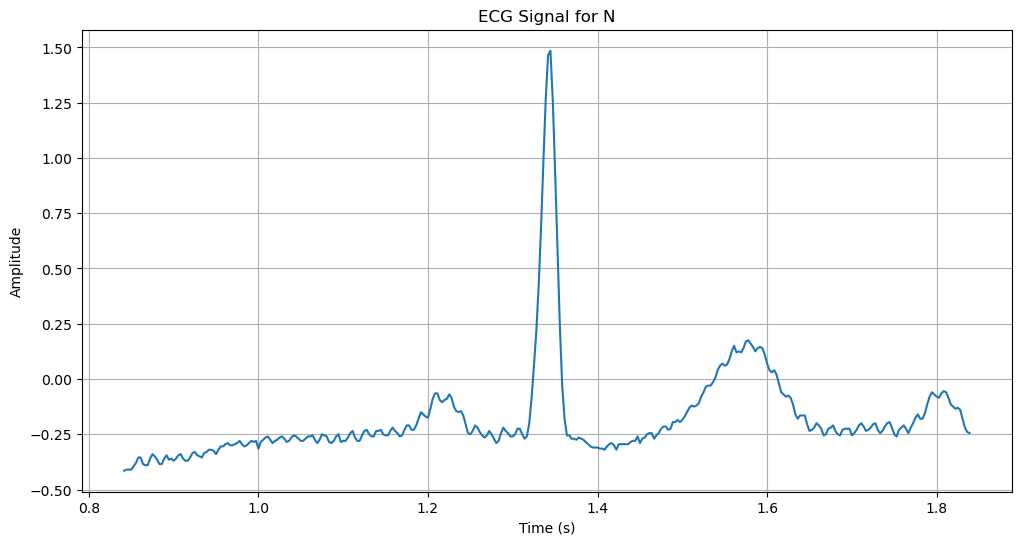

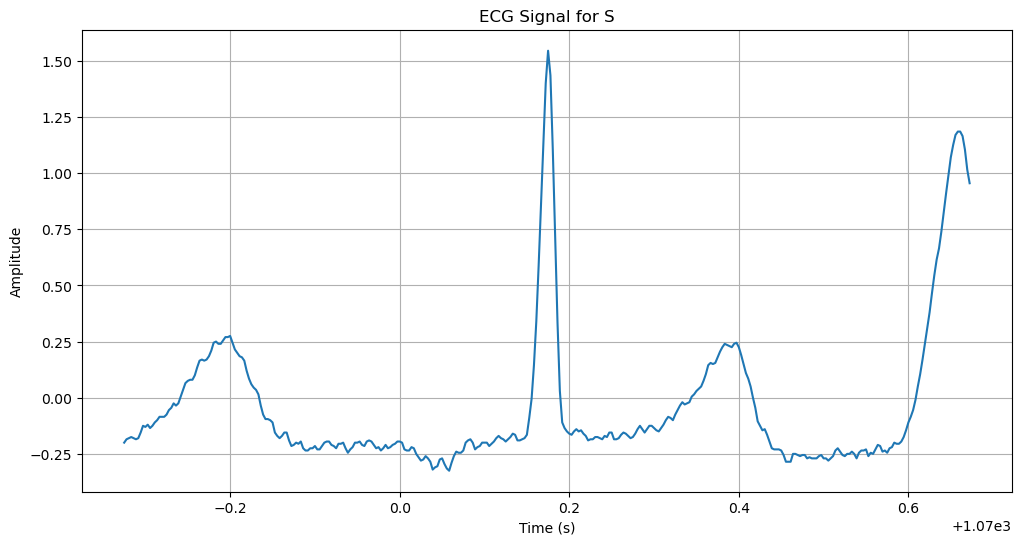

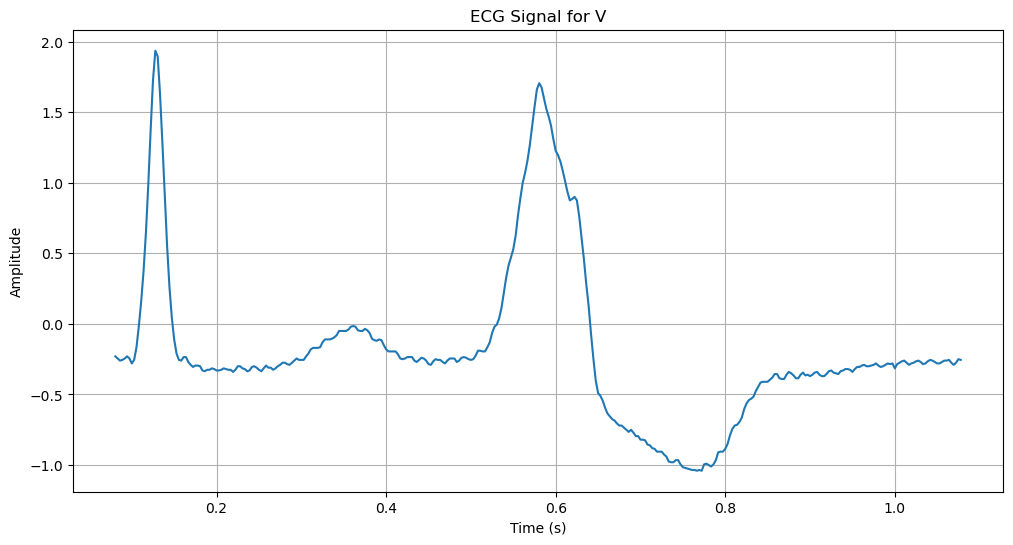

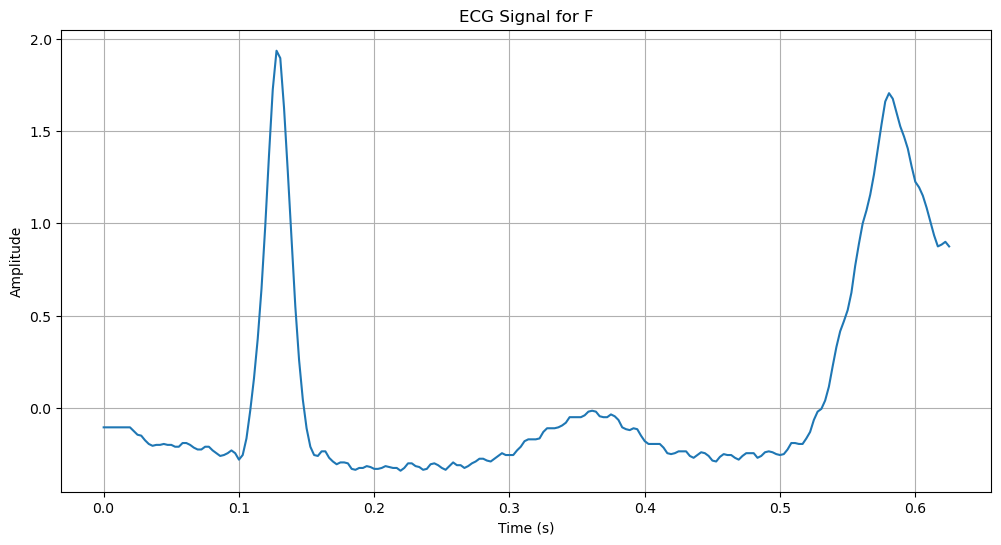

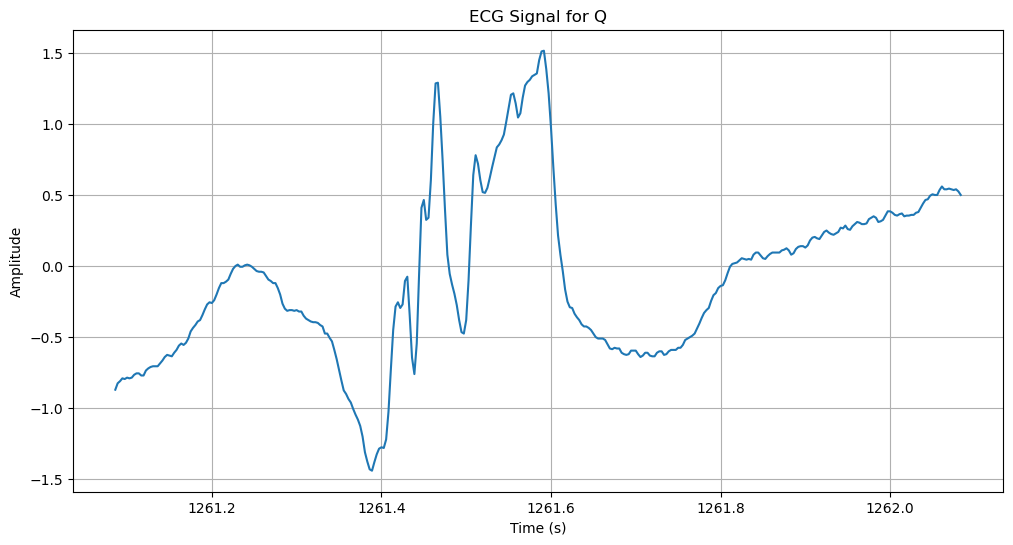

In [5]:
import matplotlib.pyplot as plt
import numpy as np

record_name = '208'

# 특정 파일의 데이터와 annotation파일 불러오기
record = wfdb.rdrecord(f'data/{record_name}')
annotation = wfdb.rdann(f'data/{record_name}', 'atr')

# 각 aami 클래스 별 시작 위치를 저장
label_positions = {label: None for label in aami_classes}

for idx, symbol in enumerate(annotation.symbol):
    for aami_class, symbols in aami_classes.items():
        if symbol in symbols and label_positions[aami_class] is None:
            label_positions[aami_class] = annotation.sample[idx]

# 각 class의 첫 point 출력
for aami_class, position in label_positions.items():
    print(f"{aami_class}: {position}")

# signal을 확인
for aami_class, position in label_positions.items():
    start_idx = max(position - 180, 0)
    end_idx = min(position + 180, len(record.p_signal))
    signal_segment = record.p_signal[start_idx:end_idx, 0]  # First channel
    time_segment = np.arange(start_idx, end_idx) / record.fs

    plt.figure(figsize=(12, 6))
    plt.plot(time_segment, signal_segment, label='ECG Signal')
    plt.title(f'ECG Signal for {aami_class}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    





가공하기 쉽게 peak기준 -180~180 데이터를 csv로 저장

In [6]:
import pandas as pd

# annotation과 signal 저장
input_csv = 'data_original.csv'
output_csv = 'data_output.csv'

slicelength = 360
half = slicelength/2

for record_name in records:

    record = wfdb.rdrecord(f'data/{record_name}')
    annotation = wfdb.rdann(f'data/{record_name}', 'atr')

    for idx, symbol in enumerate(annotation.symbol):
        for aami_class, symbols in aami_classes.items():
            if symbol in symbols:
                position = annotation.sample[idx]
                start_idx = max(position - half, 0)
                end_idx = min(position + half, len(record.p_signal))
                signal_segment = record.p_signal[start_idx:end_idx, 0]  # First channel

                if len(signal_segment) < slicelength:
                    signal_segment = np.pad(signal_segment, (0, slicelength - len(signal_segment)), 'constant')

                signal_df = pd.DataFrame(signal_segment).T  # Transpose to make it a single row
                signal_df.to_csv(input_csv, mode='a', header=False, index=False)

                label_df = pd.DataFrame([aami_class])
                label_df.to_csv(output_csv, mode='a', header=False, index=False)

print(f"Signals have been saved to {input_csv}, and labels have been saved to {output_csv}.")

Signals have been saved to data_input.csv, and labels have been saved to data_output.csv.
